In [2]:
library(tidyverse)
library(data.table)
library(magrittr)
library(ggridges)
library(ggthemes)
library(harmony)
library(singlecellmethods)
library(ggrepel)
library(Matrix)
library(patchwork)
library(sctransform)
library(scales)
library(uwot)
library(pheatmap)


fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}


# Make small test dataset

    TODO: make sparse dataset, make sure pct_in and pct_out still work
    TODO: remove . from all name, replace with _
    TODO: decide whether to report pct_in with dense matrices
    TODO: figure out how to deal with missing values (NA, NULL, Inf)

In [3]:
ngenes <- 25
ncells <- 50

samples1 <- matrix(rpois(55 * ngenes, 1), nrow = ngenes)
samples2 <- matrix(rpois(45 * ngenes, c(5, 7.5, 10, 12.5, 15) / 10), nrow = ngenes)
samples3 <- matrix(rpois(50 * ngenes, rev(c(5, 7.5, 10, 12.5, 15) / 10)), nrow = ngenes)


exprs <- Reduce(cbind, list(samples1, samples2, samples3))
meta_data <- data.frame(
#     type = rep(c('A', 'B', 'C'), each = ncells),
    type = rep(c('A', 'B', 'C'), c(55, 45, 50)),
    nUMI = colSums(exprs),
    nGene = colSums(exprs > 0)
)
head(meta_data)


colnames(exprs) <- paste0('X', seq_len(ncol(exprs)))
row.names(exprs) <- paste0('G', seq_len(nrow(exprs)))

type,nUMI,nGene
A,21,16
A,22,16
A,26,18
A,18,12
A,29,16
A,21,17


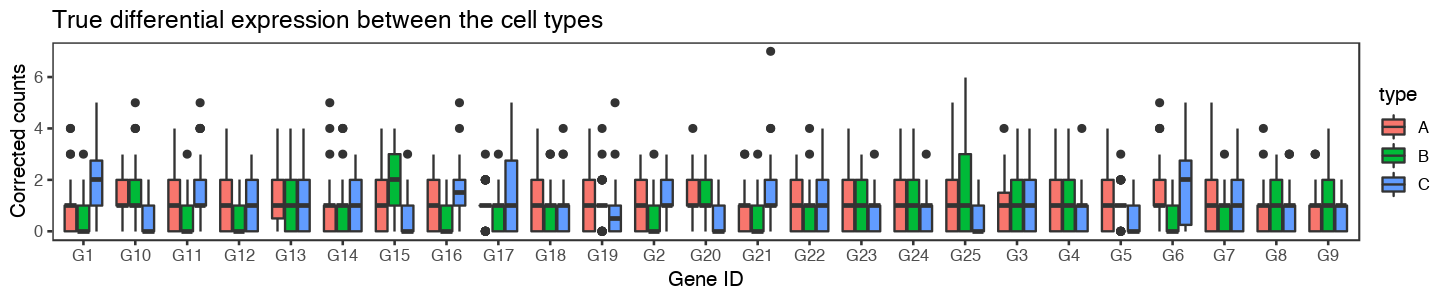

In [4]:
fig.size(2.5, 12)
exprs %>% 
    t %>% data.frame() %>% 
    cbind(meta_data) %>% 
    tidyr::gather(gene, val, -type, -nUMI, -nGene) %>%
    ggplot(aes(gene, val, fill = type)) + 
        geom_boxplot() + 
        theme_test(base_size = 12) + 
        labs(x = 'Gene ID', y = 'Corrected counts', 
             title = 'True differential expression between the cell types')

# Matrix formats

In [5]:
devtools::load_all()

Loading wilcoxauc


## Baseline with R

In [6]:
Xt <- t(exprs)
y <- factor(meta_data$type)

In [7]:
N <- nrow(meta_data)
D <- nrow(exprs)
res_base_r <- split(seq_len(N), meta_data$type) %>% lapply(function(idx) {
    res <- Reduce(rbind, apply(exprs, 1, function(g) {
        wilcox.test(g[idx], g[setdiff(seq_len(N), idx)], alternative = 'greater') %>% 
            broom::tidy()
    })) %>% data.frame()
    row.names(res) <- row.names(exprs)
    return(res)
})


In [362]:
# res_base_r

# Input data structures

In [8]:
devtools::load_all()

Loading wilcoxauc


In [11]:
X <- base::t(Xt)
X_dgc <- as(base::t(Xt), 'dgCMatrix')

x1 <- fast_diff_exp(X, y)
x2 <- fast_diff_exp(X_dgc, y)

In [13]:
# x2$fdr %>% head

all(x1$auc == x2$auc)
all(x1$fdr == x2$fdr)
all(x1$lfc == x2$lfc)
all(x1$means == x2$means)
all(x1$means_nz == x2$means_nz)
all(x1$pct_in == x2$pct_in)
all(x1$pct_out == x2$pct_out)

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [14]:
x <- fast_wilcox(Xt, y)
x <- fast_wilcox(as(Xt, 'dgCMatrix'), y)
x <- fast_wilcox(as(Xt, 'dgTMatrix'), y)
x <- fast_wilcox(as(Xt, 'dgeMatrix'), y)
x <- fast_wilcox(as(Xt, 'TsparseMatrix'), y)


x <- fast_diff_exp(X, y)
x <- fast_diff_exp(as(X, 'dgCMatrix'), y)
x <- fast_diff_exp(as(X, 'dgTMatrix'), y)
x <- fast_diff_exp(as(X, 'dgeMatrix'), y)
x <- fast_diff_exp(as(X, 'TsparseMatrix'), y)


All other sparse and dense types are transformed into dgCMatrix and matrix

In [15]:
devtools::use_data()

Warning message:
“'devtools::use_data' is deprecated.
Use 'usethis::use_data()' instead.
See help("Deprecated") and help("devtools-deprecated").”

✔ Setting active project to '/Users/ikorsuns/Projects/wilcoxauc'


ERROR: Error: Nothing to save.


# Dealing with ties

http://www.statstutor.ac.uk/resources/uploaded/mannwhitney.pdf

In [17]:
devtools::load_all()

Loading wilcoxauc


In [56]:
N <- 10000
G <- 5000
Xt <- t(matrix(rpois(N * G, .2), nrow = G))
Xt_dgc <- as(Xt, 'dgCMatrix')
y <- sample(10, N, TRUE)

## ratio of non-zero elements
length(Xt_dgc@x) / prod(dim(Xt_dgc))

[1] 0.18125

In [57]:
system.time({
    x <- fast_wilcox(Xt, y)
})
system.time({
    x2 <- fast_wilcox(Xt_dgc, y)
})

   user  system elapsed 
  3.202   0.335   3.575 

   user  system elapsed 
  0.451   0.042   0.495 